# Estimate ELAs and fit linear trendlines to $\Sigma PDDs + \Sigma Snowfall = ELA$ to assess ELA sensivities

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from tqdm.auto import tqdm
from scipy.stats import median_abs_deviation as MAD
from scipy.interpolate import CubicSpline
import sys
import seaborn as sns
# Suppress future warning from pandas
import warnings
warnings.filterwarnings("ignore")
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import ruptures as rpt
from scipy import optimize

In [2]:
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/'
sys.path.append(os.path.join(base_path, 'functions'))
import model_analyze_utils as f

# scm_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/'
scm_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/'

## Load glacier boundaries, ERA5-Land data, and compiled snow cover stats

In [3]:
# -----Load glacier boundaries with climate clusters
aois_fn = os.path.join(scm_path, 'compiled_data', 'all_aois_climate_cluster.shp')
aois = gpd.read_file(aois_fn)
aois[['O1Region', 'O2Region']] = aois[['O1Region', 'O2Region']].astype(int)
print('All AOIs with climate clusters loaded from file.')

# -----Load ERA data
eras_fn = os.path.join(scm_path, 'compiled_data', 'all_era_data.csv')
eras = pd.read_csv(eras_fn)
# format dates as datetimes
eras['Date'] = pd.to_datetime(eras['Date'])
# rename "site_name" column to "RGIId"
eras.rename(columns={'site_name': 'RGIId'}, inplace=True)
# Add Year and Month columns
eras['Year'] = pd.DatetimeIndex(eras['Date']).year
eras['Month'] = pd.DatetimeIndex(eras['Date']).month
print('All ERA data loaded from file.')

# -----Define snow cover stats file name (only load if ELAs don't exist, it's a big file!)
scs_fn = os.path.join(scm_path, 'compiled_data', 'all_snow_cover_stats.csv')
scs = None 

All AOIs with climate clusters loaded from file.
All ERA data loaded from file.


## Estimate and save ELAs

### Remotely-sensed

In [4]:
# -----Monthly mean ELAs
# Check if ELAs already exist in file
obs_elas_monthly_fn = os.path.join(scm_path, 'results', 'observed_monthly_elas.csv')
if os.path.exists(obs_elas_monthly_fn):
    obs_elas_monthly = pd.read_csv(obs_elas_monthly_fn)
    obs_elas_monthly['Date'] = pd.to_datetime(obs_elas_monthly['Date'])
    print('Remotely-sensed monthly ELAs loaded from file.')
else:
    # Load compiled snow cover stats
    if scs is None:
        scs = pd.read_csv(scs_fn)
        scs['datetime'] = pd.to_datetime(scs['datetime'], format='mixed')
        # Remove wonky ELA values
        scs.loc[scs['ELA_from_AAR_m'] > 1e10, 'ELA_from_AAR_m'] = np.nan
        # Add Year and Month columns
        scs['Year'] = pd.DatetimeIndex(scs['datetime']).year
        scs['Month'] = pd.DatetimeIndex(scs['datetime']).month
        print('All snow cover stats loaded from file.')
        
        # Add Year and Month columns to snow cover stats
        scs['Year'] = pd.DatetimeIndex(scs['datetime']).year
        scs['Month'] = pd.DatetimeIndex(scs['datetime']).month
    
    # Calculate the mean. monthly ELA at each site
    obs_elas_monthly = scs.groupby(by=['RGIId', 'Year', 'Month'])['ELA_from_AAR_m'].mean().reset_index()

    # Add mean monthly PDDs and snowfall
    eras['Year'] = pd.DatetimeIndex(eras['Date']).year
    eras['Month'] = pd.DatetimeIndex(eras['Date']).month
    eras_monthly = eras.groupby(by=['RGIId', 'Year', 'Month'])[['Cumulative_Positive_Degree_Days', 
                                                                'Cumulative_Snowfall_mwe']].mean().reset_index()
    obs_elas_monthly = obs_elas_monthly.merge(eras_monthly, on=['RGIId', 'Year', 'Month'])
    
    # Add Date column
    obs_elas_monthly['Date'] = [np.datetime64(f'{year}-{month}-01') if month >=10 else 
                                np.datetime64(f'{year}-0{month}-01')
                                for year, month in obs_elas_monthly[['Year', 'Month']].values]

    # Reorder columns
    obs_elas_monthly = obs_elas_monthly[['RGIId', 'Date', 'Year', 'Month', 'ELA_from_AAR_m', 
                                         'Cumulative_Positive_Degree_Days', 
                                         'Cumulative_Snowfall_mwe']]
    # Save to file
    obs_elas_monthly.to_csv(obs_elas_monthly_fn, index=False)
    print('Remotely-sensed monthly ELAs saved to file:', obs_elas_monthly_fn)

obs_elas_monthly

Remotely-sensed monthly ELAs loaded from file.


,RGIId,Date,Year,Month,ELA_from_AAR_m,Cumulative_Positive_Degree_Days,Cumulative_Snowfall_mwe
0,RGI60-01.00032,2013-05-01,2013,5,1447.721700,2.018662,0.267464
1,RGI60-01.00032,2013-10-01,2013,10,1438.106300,419.985946,0.044374
2,RGI60-01.00032,2014-06-01,2014,6,1519.748900,7.180895,0.417849
3,RGI60-01.00032,2014-10-01,2014,10,1427.690200,195.241593,0.033835
4,RGI60-01.00032,2015-10-01,2015,10,1404.903400,319.604363,0.020348
...,...,...,...,...,...,...,...
10038,RGI60-02.18778,2023-06-01,2023,6,1740.935915,305.409907,1.460171
10039,RGI60-02.18778,2023-07-01,2023,7,1800.693245,627.060482,1.498596
10040,RGI60-02.18778,2023-08-01,2023,8,1991.261304,1019.671947,1.520705
10041,RGI60-02.18778,2023-09-01,2023,9,1947.385305,1348.067095,1.568974


In [5]:
# -----Annual ELAs
# Check if ELAs already exist in file
obs_elas_annual_fn = os.path.join(scm_path, 'results', 'observed_annual_elas.csv')
if os.path.exists(obs_elas_annual_fn):
    obs_elas_annual = pd.read_csv(obs_elas_annual_fn)
    obs_elas_annual['Date'] = pd.to_datetime(obs_elas_annual['Date'])
    print('Remotely-sensed annual ELAs loaded from file.')
else:
    # Identify indices of maximum annual ELA
    Imax = scs.groupby(by=['RGIId', 'Year'])['ELA_from_AAR_m'].idxmax().dropna().values.astype(int)
    obs_elas_annual = scs[['RGIId', 'datetime', 'Year', 'ELA_from_AAR_m']].iloc[Imax]
    obs_elas_annual.rename(columns={'datetime': 'Date'}, inplace=True)
    obs_elas_annual['Date'] = obs_elas_annual['Date'].values.astype('datetime64[D]')
    # Grab with ERA5 data for each date
    obs_elas_annual = obs_elas_annual.merge(eras[['RGIId', 'Date', 
                                                  'Cumulative_Positive_Degree_Days', 
                                                  'Cumulative_Snowfall_mwe']], on=['RGIId', 'Date'])
    # Save to file
    obs_elas_annual.to_csv(obs_elas_annual_fn, index=False)
    print('Remotely-sensed annual ELAs saved to file:', obs_elas_annual_fn)

obs_elas_annual

Remotely-sensed annual ELAs loaded from file.


,RGIId,Date,Year,ELA_from_AAR_m,Cumulative_Positive_Degree_Days,Cumulative_Snowfall_mwe
0,RGI60-01.00032,2013-05-26,2013,1447.721700,0.152943,0.292789
1,RGI60-01.00032,2014-06-07,2014,1519.748900,2.559441,0.365826
2,RGI60-01.00032,2015-10-23,2015,1404.903400,319.604363,0.025806
3,RGI60-01.00032,2016-08-31,2016,2297.331300,325.382745,0.644991
4,RGI60-01.00032,2017-08-06,2017,2770.615200,290.180963,0.457518
...,...,...,...,...,...,...
2087,RGI60-02.18778,2019-08-19,2019,2109.720000,872.838123,1.570425
2088,RGI60-02.18778,2020-10-17,2020,2178.168889,1289.953788,0.158769
2089,RGI60-02.18778,2021-06-16,2021,2150.500000,185.937996,1.933916
2090,RGI60-02.18778,2022-10-12,2022,2077.210000,1411.405586,0.001758


### Modeled

In [43]:
# Functions for linearly extrapolating the ELA when modeled SMB < 0 everywhere
def linear_fit(x, m, b):
    return m*x + b
    
def extrapolate_ela_linear(X,y, Iend=8):
    # optimize the linear fit
    p, e = optimize.curve_fit(linear_fit, X[0:Iend+1], y[0:Iend+1])
    # extrapolate where y=0
    ela = linear_fit(0, *p)
    return ela

In [61]:
# -----Monthly ELAs
mod_elas_monthly_fn = os.path.join(scm_path, 'results', 'modeled_monthly_elas.csv')
if os.path.exists(mod_elas_monthly_fn):
    mod_elas_monthly = pd.read_csv(mod_elas_monthly_fn)
    mod_elas_monthly['Date'] = pd.DatetimeIndex(mod_elas_monthly['Date'])
    print('Modeled monthly ELAs loaded from file.')
else:
    
    # load binned model data
    bin_fns = sorted(glob.glob(os.path.join(scm_path, 'Rounce_et_al_2023', 'binned', '*.nc')))
    
    # remove binned file names for sites without snow cover observations
    aoi_ids = [x[7:] for x in aois['RGIId'].drop_duplicates().values]
    bin_fns = [x for x in bin_fns if os.path.basename(x)[0:7] in aoi_ids]

    # initialize dataframe for results
    mod_elas_monthly = pd.DataFrame()

    # iterate over binned file names
    i=0
    for bin_fn in tqdm(bin_fns):
        # open binned data
        bin = xr.open_dataset(bin_fn)
        rgi_id = bin.RGIId.data[0] # grab RGI ID

        # grab data variables
        h = bin.bin_surface_h_initial.data[0] # surface elevation [m]
        b_sum = np.zeros((len(bin.time.data), len(h))) # cumulative SMB
        times = [np.datetime64(x) for x in bin.time.data] # datetimes
        months = list(pd.DatetimeIndex(times).month) # months of each datetime
        elas = np.zeros(len(times)) # initialize transient ELAs

        # iterate over each time period
        for j, time in enumerate(times):
            # subset binned data to time
            bin_time = bin.isel(time=j)
            # grab the SMB 
            b_sum[j,:] = bin_time.bin_massbalclim_monthly.data[0]
            # add the previous SMB (restart the count in October)
            if months[j] != 10: 
                b_sum[j,:] += b_sum[j-1,:]
            # If all SMB > 0, ELA = minimum elevation
            if all(b_sum[j,:] > 0):
                elas[j] = np.min(h)
            # If SMB is > 0 and < 0 in some places, linearly interpolate ELA
            elif any(b_sum[j,:] < 0) & any(b_sum[j,:] > 0):
                elas[j] = np.interp(0, np.flip(b_sum[j,:]), np.flip(h))
            # If SMB < 0 everywhere, fit a piecewise linear fit and extrapolate for SMB=0
            elif all(b_sum[j,:] < 0):
                X, y = b_sum[j,:], h
                elas[j] = extrapolate_ela_linear(X, y, Iend=5)
            else:
                print('issue')

        # compile in dataframe
        df = pd.DataFrame({'Date': times,
                           'ELA_m': elas})
        
        # Because each SMB value represents the total SMB for each month, add 1 month to the dates
        df['Date'] = df['Date'] + pd.DateOffset(months=1)
        df['RGIId'] = rgi_id

        # Add ERA5 data for each date
        eras_site = eras.loc[eras['RGIId']==rgi_id]
        eras_site = eras_site[['Date', 'Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe']]
        df = df.merge(eras_site, on='Date')
        mod_elas_monthly = pd.concat([mod_elas_monthly, df])
            
        i+=1

    # Rearrange columns
    mod_elas_monthly = mod_elas_monthly[['RGIId', 'Date', 'ELA_m', 
                                         'Cumulative_Positive_Degree_Days', 
                                         'Cumulative_Snowfall_mwe']]
    # save to file
    mod_elas_monthly.to_csv(mod_elas_monthly_fn, index=False)
    print('Modeled transient ELAs saved to file:', mod_elas_monthly_fn)

mod_elas_monthly.reset_index(drop=True, inplace=True)
mod_elas_monthly

  0%|          | 0/194 [00:00<?, ?it/s]

Modeled transient ELAs saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/results/modeled_monthly_elas.csv


,RGIId,Date,ELA_m,Cumulative_Positive_Degree_Days,Cumulative_Snowfall_mwe
0,RGI60-01.00032,2012-11-01,1430.317692,0.000000,0.000471
1,RGI60-01.00032,2012-12-01,1430.317692,0.000000,0.015097
2,RGI60-01.00032,2013-01-01,1430.317692,0.000000,0.036026
3,RGI60-01.00032,2013-02-01,1430.317692,0.000000,0.095413
4,RGI60-01.00032,2013-03-01,1430.317692,0.000000,0.131147
...,...,...,...,...,...
23857,RGI60-02.18778,2022-09-01,1747.136444,999.441108,2.246717
23858,RGI60-02.18778,2022-10-01,2032.139668,1293.003237,0.000001
23859,RGI60-02.18778,2022-11-01,2172.170680,1484.923959,0.161002
23860,RGI60-02.18778,2022-12-01,1949.359008,1484.923959,0.401845


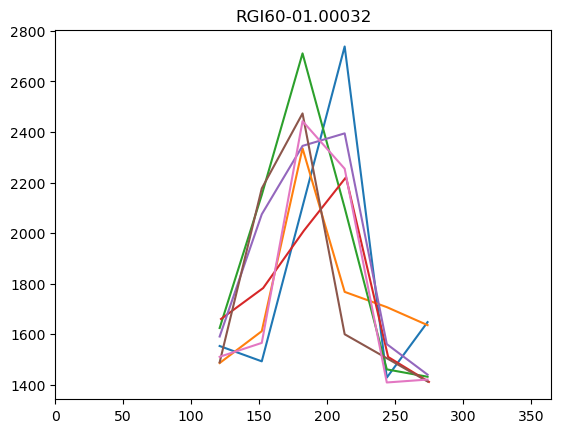

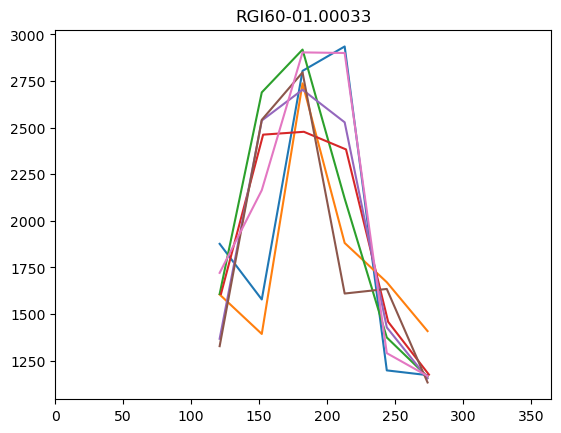

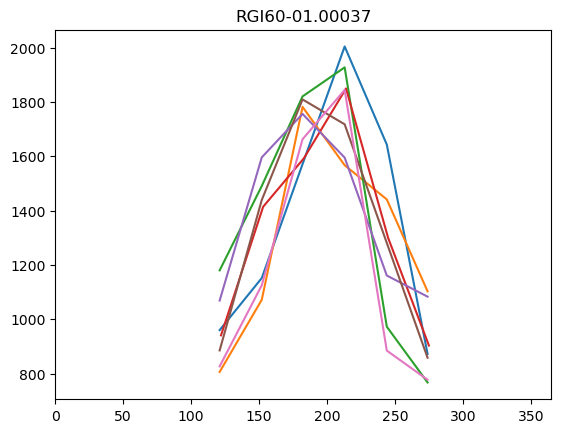

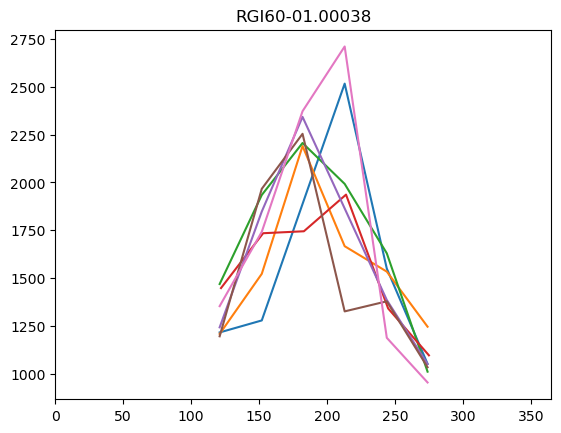

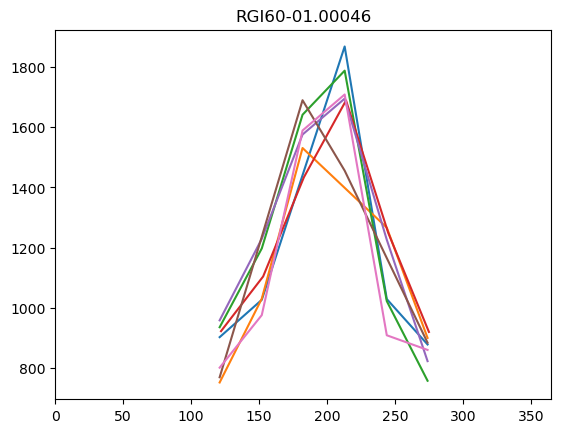

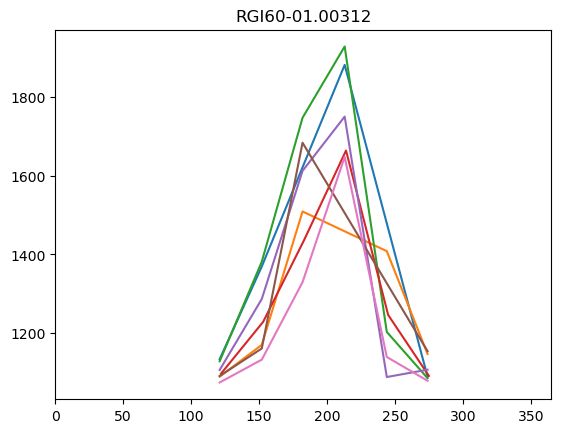

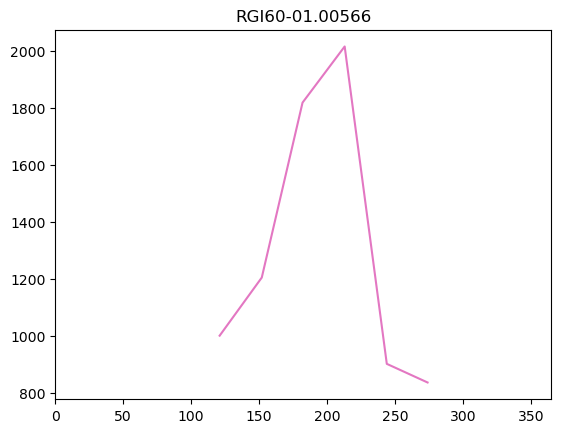

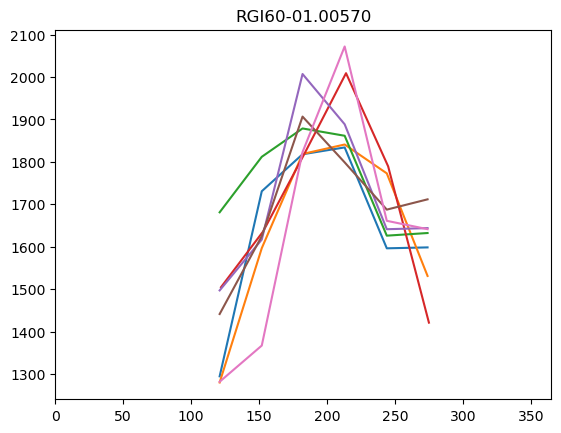

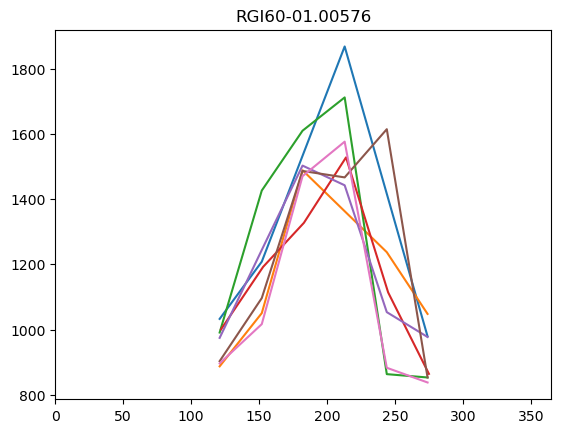

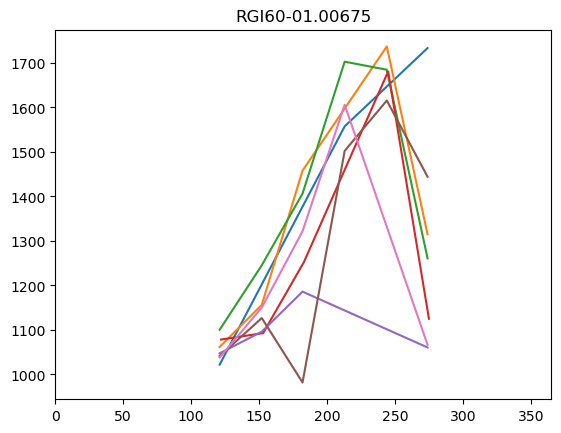

In [70]:
obs_elas_monthly['Year'] = pd.DatetimeIndex(obs_elas_monthly['Date']).year
obs_elas_monthly['DOY'] = pd.DatetimeIndex(obs_elas_monthly['Date']).dayofyear
for rgi_id in obs_elas_monthly['RGIId'].drop_duplicates().values[0:10]:
    obs_elas_monthly_site = obs_elas_monthly.loc[obs_elas_monthly['RGIId']==rgi_id]
    obs_elas_monthly_site = obs_elas_monthly_site.loc[obs_elas_monthly_site['Year'] > 2016]
    plt.figure()
    for year in obs_elas_monthly_site['Year'].drop_duplicates().values:
        plt.plot(obs_elas_monthly_site.loc[obs_elas_monthly_site['Year']==year, 'DOY'],
                 obs_elas_monthly_site.loc[obs_elas_monthly_site['Year']==year, 'ELA_from_AAR_m'], '-')
    plt.xlim(0,365)
    plt.title(rgi_id)
    plt.show()

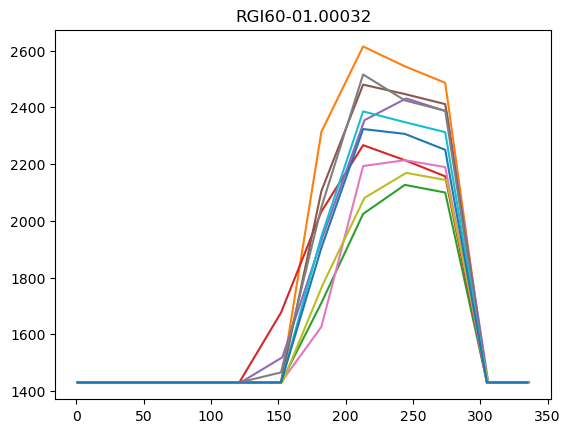

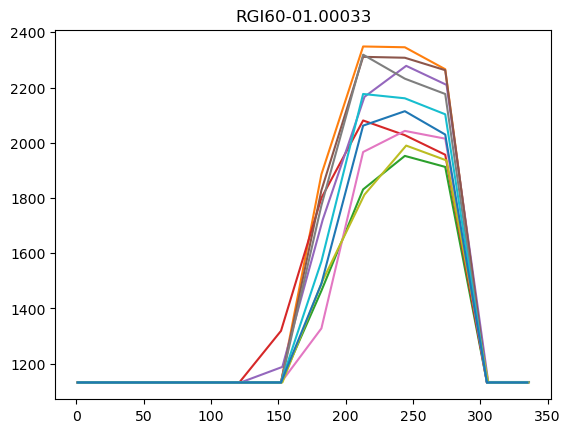

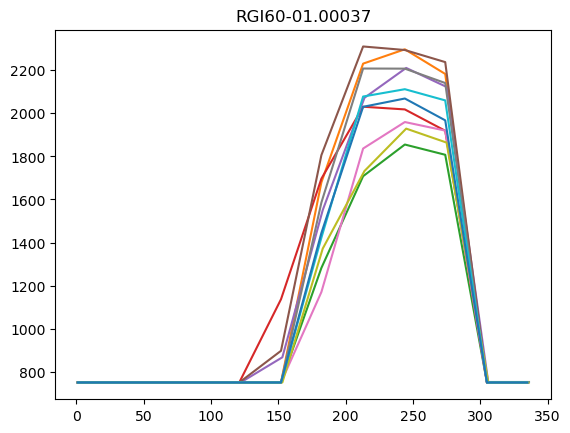

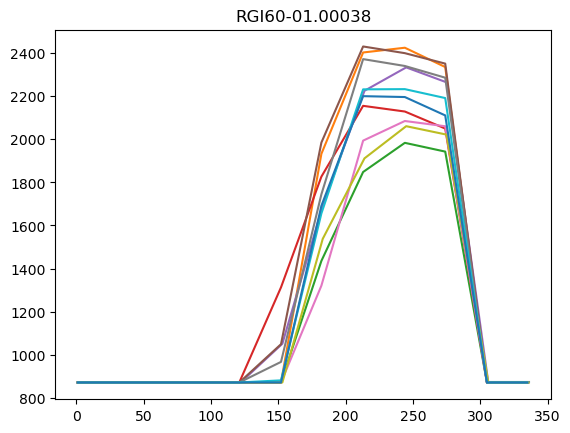

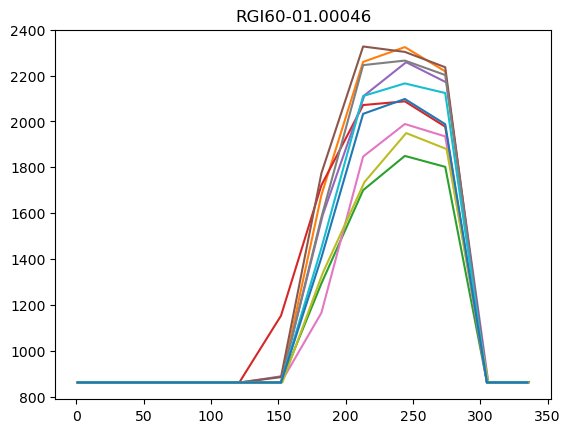

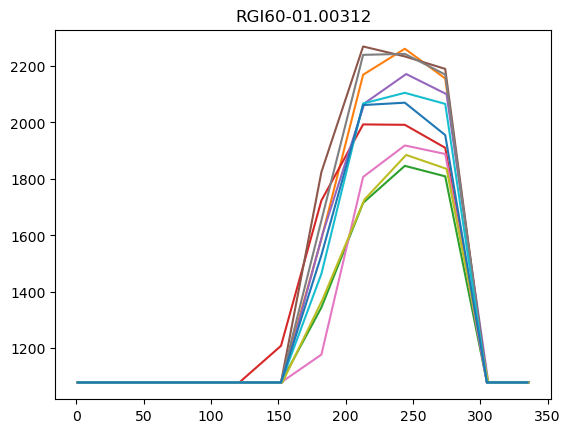

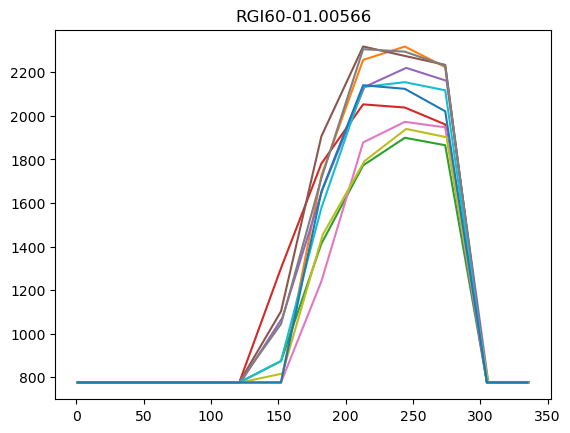

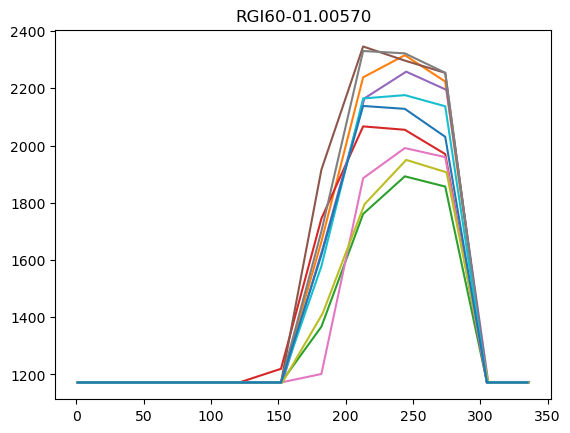

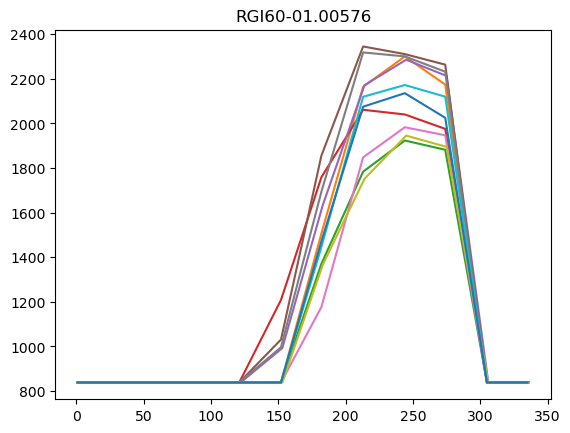

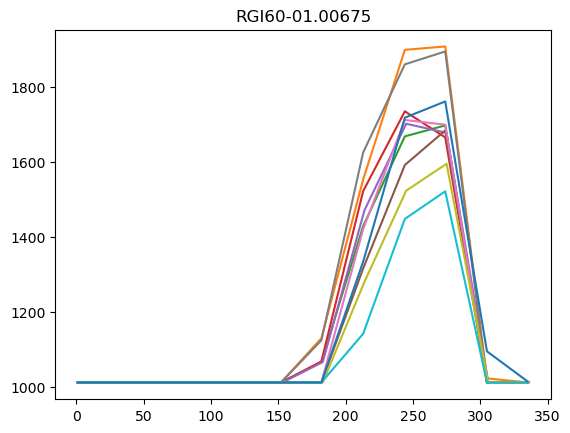

In [65]:
mod_elas_monthly['Year'] = pd.DatetimeIndex(mod_elas_monthly['Date']).year
mod_elas_monthly['DOY'] = pd.DatetimeIndex(mod_elas_monthly['Date']).dayofyear
for rgi_id in mod_elas_monthly['RGIId'].drop_duplicates().values[0:10]:
    mod_elas_monthly_site = mod_elas_monthly.loc[mod_elas_monthly['RGIId']==rgi_id]
    
    plt.figure()
    for year in mod_elas_monthly_site['Year'].drop_duplicates().values:
        plt.plot(mod_elas_monthly_site.loc[mod_elas_monthly_site['Year']==year, 'DOY'],
                 mod_elas_monthly_site.loc[mod_elas_monthly_site['Year']==year, 'ELA_m'], '-')
    plt.title(rgi_id)
    plt.show()

In [45]:
# -----Annual ELAs
mod_elas_annual_fn = os.path.join(scm_path, 'results', 'modeled_annual_elas.csv')
if os.path.exists(mod_elas_annual_fn):
    mod_elas_annual = pd.read_csv(mod_elas_annual_fn)
    mod_elas_annual['Date'] = pd.to_datetime(mod_elas_annual['Date'])
    print('Modeled annual ELAs loaded from file.')
else:
    # Add Year column
    mod_elas_monthly['Year'] = pd.DatetimeIndex(mod_elas_monthly['Date']).year
    # Identify the row of maximum ELA for each site and each year
    Imax = mod_elas_monthly.groupby(by=['RGIId', 'Year'])['ELA_m'].idxmax().values
    mod_elas_annual = mod_elas_monthly.iloc[Imax].reset_index(drop=True)
    # Reorder columns
    mod_elas_monthly = mod_elas_monthly[['RGIId', 'Date', 'Year', 'ELA_m', 
                                         'Cumulative_Positive_Degree_Days',
                                         'Cumulative_Snowfall_mwe']]
    # Save to file
    mod_elas_annual.to_csv(mod_elas_annual_fn, index=False)
    print('Modeled annual ELAs saved to file:', mod_elas_annual_fn)
    
mod_elas_annual

Modeled annual ELAs loaded from file.


,RGIId,Date,Year,ELA_m,Cumulative_Positive_Degree_Days,Cumulative_Snowfall_mwe
0,RGI60-01.00032,2012-11-01,2012,1430.317692,0.000000,0.000471
1,RGI60-01.00032,2013-08-01,2013,2614.503745,325.809940,0.454583
2,RGI60-01.00032,2014-09-01,2014,2126.715067,187.425379,0.738059
3,RGI60-01.00032,2015-08-01,2015,2266.612695,258.587416,0.516373
4,RGI60-01.00032,2016-09-01,2016,2431.285897,327.698403,0.644992
...,...,...,...,...,...,...
2323,RGI60-02.18778,2019-10-01,2019,2187.026191,1203.387599,0.000013
2324,RGI60-02.18778,2020-10-01,2020,2025.103496,1211.252127,0.000000
2325,RGI60-02.18778,2021-10-01,2021,2135.926640,1388.275927,0.000770
2326,RGI60-02.18778,2022-11-01,2022,2172.170680,1484.923959,0.161002


## Compare modeled to observed ELAs

### Monthly ELAs

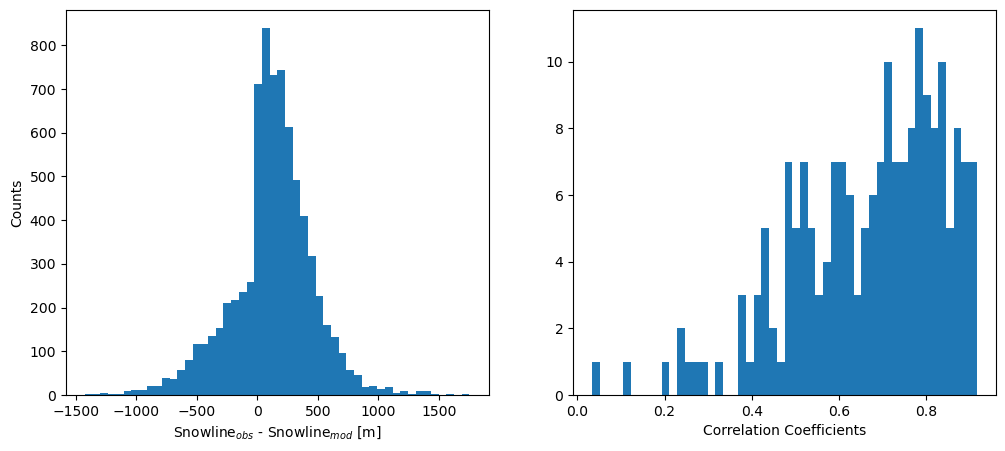

Merged monthly ELAs saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/results/ELAs_monthly_mod_obs_merged.csv
Correlation coefficients saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/results/ELAs_monthly_correlation_coefficients.csv

Difference stats:
Mean diff = 124.86496614727986 m
Std. diff = 336.88626327212194 m
Median diff = 137.1271999999999 m
MAD diff = 164.58117023117643 m

 Corr. Coef. stats:
Mean =  0.6689482680544195
Std. =  0.17373963064624753
Median =  0.7065290454666182
MAD =  0.11900341801983438


In [79]:
# Merge modeled and remotely-sensed modeled ELAs
elas_monthly_merged = mod_elas_monthly[['RGIId', 'Date', 'ELA_m']].merge(obs_elas_monthly[['RGIId', 'Date', 'ELA_from_AAR_m']], 
                                                                         on=['RGIId', 'Date'])
# Remove 2023 values (no modeled data in 2023)
elas_monthly_merged = elas_monthly_merged.loc[pd.DatetimeIndex(elas_monthly_merged['Date']).year < 2023]

# Remove observations outside May - September
elas_monthly_merged = elas_monthly_merged.loc[(pd.DatetimeIndex(elas_monthly_merged['Date']).month >=5) 
                                            & (pd.DatetimeIndex(elas_monthly_merged['Date']).month <=9)]

# Load compiled snow cover stats for minimum elevations
if scs is None:
    scs = pd.read_csv(scs_fn)
    scs['datetime'] = pd.to_datetime(scs['datetime'], format='mixed')
    # Remove wonky ELA values
    scs.loc[scs['ELA_from_AAR_m'] > 1e10, 'ELA_from_AAR_m'] = np.nan
    # Add Year and Month columns
    scs['Year'] = pd.DatetimeIndex(scs['datetime']).year
    scs['Month'] = pd.DatetimeIndex(scs['datetime']).month
    print('All snow cover stats loaded from file.')

# Initialize dataframe for correlation coefficients
corr_coefs_df = pd.DataFrame()
# Iterate over RGI IDs
for rgi_id in elas_monthly_merged['RGIId'].drop_duplicates().values:
    # Subtract the minimum ELA for each site to avoid datum issues, s.t. ELAs are with respect to zero meters
    elas_monthly_merged.loc[elas_monthly_merged['RGIId']==rgi_id, 'ELA_m'] -= mod_elas_monthly.loc[mod_elas_monthly['RGIId']==rgi_id, 'ELA_m'].min()
    elas_monthly_merged.loc[elas_monthly_merged['RGIId']==rgi_id, 'ELA_from_AAR_m'] -= scs.loc[scs['RGIId']==rgi_id, 'ELA_from_AAR_m'].min()
    # Calculate correlation coefficient
    elas_monthly_merged_site = elas_monthly_merged.loc[elas_monthly_merged['RGIId']==rgi_id]
    corr_coef_site = elas_monthly_merged_site[['ELA_from_AAR_m', 'ELA_m']].corr().values[0][1]
    corr_coef_df = pd.DataFrame({'RGIId': [rgi_id], 
                                 'Correlation Coefficient': [corr_coef_site]})
    corr_coefs_df = pd.concat([corr_coefs_df, corr_coef_df])

# Rename columns
corr_coefs_df.reset_index(drop=True, inplace=True)
elas_monthly_merged.rename(columns={'ELA_m': 'ELA_mod_m', 'ELA_from_AAR_m': 'ELA_obs_m'}, inplace=True)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].hist(elas_monthly_merged['ELA_obs_m'] - elas_monthly_merged['ELA_mod_m'], bins=50)
ax[0].set_xlabel('Snowline$_{obs}$ - Snowline$_{mod}$ [m]')
ax[0].set_ylabel('Counts')
ax[1].hist(corr_coefs_df['Correlation Coefficient'], bins=50)
ax[1].set_xlabel('Correlation Coefficients')
plt.show()

# Save results
elas_monthly_merged_fn = os.path.join(scm_path, 'results', 'ELAs_monthly_mod_obs_merged.csv')
elas_monthly_merged.to_csv(elas_monthly_merged_fn, index=False)
print('Merged monthly ELAs saved to file:', elas_monthly_merged_fn)
corr_coefs_fn = os.path.join(scm_path, 'results', 'ELAs_monthly_correlation_coefficients.csv')
corr_coefs_df.to_csv(corr_coefs_fn, index=False)
print('Correlation coefficients saved to file:', corr_coefs_fn)

print('\nDifference stats:')
print(f'Mean diff = {np.nanmean((elas_monthly_merged["ELA_obs_m"] - elas_monthly_merged["ELA_mod_m"]).values)} m')
print(f'Std. diff = {np.nanstd((elas_monthly_merged["ELA_obs_m"] - elas_monthly_merged["ELA_mod_m"]).values)} m')
print(f'Median diff = {np.nanmedian((elas_monthly_merged["ELA_obs_m"] - elas_monthly_merged["ELA_mod_m"]).values)} m')
print(f'MAD diff = {MAD((elas_monthly_merged["ELA_obs_m"] - elas_monthly_merged["ELA_mod_m"]).values, nan_policy="omit")} m')

print('\n Corr. Coef. stats:')
print('Mean = ', np.nanmean(corr_coefs_df['Correlation Coefficient']))
print('Std. = ', np.nanstd(corr_coefs_df['Correlation Coefficient']))
print('Median = ', np.nanmedian(corr_coefs_df['Correlation Coefficient']))
print('MAD = ', MAD(corr_coefs_df['Correlation Coefficient'], nan_policy="omit"))

In [74]:
# -----See if terrain parameters correlate with the differences
elas_monthly_merged['Difference'] = elas_monthly_merged['ELA_obs_m'] - elas_monthly_merged['ELA_mod_m']

# Shift Aspect values to range from 0 to 180, where North=0, South=190, and W/E=90
def convert_aspect_to_cyclical(aspects):
    shifted_aspects = aspects
    shifted_aspects[shifted_aspects > 180] = 360 - shifted_aspects[shifted_aspects > 180]
    return shifted_aspects
aois['Aspect_shifted'] = convert_aspect_to_cyclical(aois['Aspect'].values)

# Add terrain parameters
terrain_parameters = ['Area', 'Zmed', 'Slope', 'Aspect_shifted', 'Lmax']
elas_monthly_merged_params = elas_monthly_merged.merge(aois[['RGIId'] + terrain_parameters], on='RGIId')
elas_monthly_merged_params
corrs_df = pd.DataFrame()
for param in terrain_parameters:
    corr = elas_monthly_merged_params[['Difference', param]].corr().values[0,1]
    corr_df = pd.DataFrame({'Parameter': [param], 'Pearson Correlation Coefficient': [corr]})
    corrs_df = pd.concat([corrs_df, corr_df])
corrs_df.reset_index(drop=True, inplace=True)

# Save to file
corrs_fn = os.path.join(scm_path, 'results', 'corr_coeffs_ELA_difference_terrain_parameters_monthly.csv')
corrs_df.to_csv(corrs_fn, index=False)
print('Corr. coeffs. saved to file:', corrs_fn)

corrs_df

Corr. coeffs. saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/results/corr_coeffs_ELA_difference_terrain_parameters_monthly.csv


,Parameter,Pearson Correlation Coefficient
0,Area,-0.116756
1,Zmed,0.047802
2,Slope,0.081302
3,Aspect_shifted,-0.085724
4,Lmax,-0.147836


### Annual ELAs

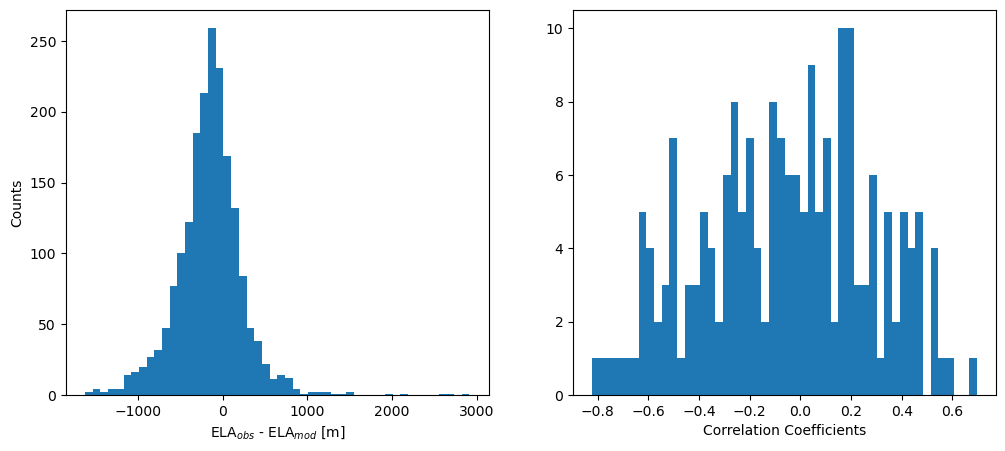

Mered monthly ELAs saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/results/ELAs_annual_mod_obs_merged.csv
Correlation coefficients saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/results/ELAs_annual_correlation_coefficients.csv

Difference stats:
Mean diff = -154.2027711949344 m
Std. diff = 391.7340919857226 m
Median diff = -142.8903710826695 m
MAD diff = 199.98841366412012 m

Corr. Coef. stats:
Mean =  -0.05702199552735108
Std. =  0.33431130746141796
Median =  -0.05311324299144842
MAD =  0.24116319497431749


In [75]:
# Merge modeled and remotely-sensed modeled ELAs
elas_annual_merged = obs_elas_annual[['RGIId', 'Year', 'ELA_from_AAR_m']].merge(mod_elas_annual[['RGIId', 'Year', 'ELA_m']],
                                                                                on=['RGIId', 'Year'])

# Remove 2023 values (no modeled data in 2023)
elas_annual_merged = elas_annual_merged.loc[elas_annual_merged['Year'] < 2023]

# Initialize dataframe for correlation coefficients
corr_coefs_df = pd.DataFrame()
# Iterate over RGI IDs
for rgi_id in elas_annual_merged['RGIId'].drop_duplicates().values:
    # Subtract the minimum ELA for each site to avoid datum issues, s.t. ELAs are with respect to zero meters
    elas_annual_merged.loc[elas_annual_merged['RGIId']==rgi_id, 'ELA_m'] -= mod_elas_monthly.loc[mod_elas_monthly['RGIId']==rgi_id, 'ELA_m'].min()
    elas_annual_merged.loc[elas_annual_merged['RGIId']==rgi_id, 'ELA_from_AAR_m'] -= scs.loc[scs['RGIId']==rgi_id, 'ELA_from_AAR_m'].min()
    # Calculate correlation coefficient
    elas_annual_merged_site = elas_annual_merged.loc[elas_annual_merged['RGIId']==rgi_id]
    corr_coef_site = elas_annual_merged_site[['ELA_from_AAR_m', 'ELA_m']].corr().values[0][1]
    corr_coef_df = pd.DataFrame({'RGIId': [rgi_id], 
                                 'Correlation Coefficient': [corr_coef_site]})
    corr_coefs_df = pd.concat([corr_coefs_df, corr_coef_df])
    
# Rename columns
corr_coefs_df.reset_index(drop=True, inplace=True)
elas_annual_merged.rename(columns={'ELA_m': 'ELA_mod_m', 'ELA_from_AAR_m': 'ELA_obs_m'}, inplace=True)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].hist(elas_annual_merged['ELA_obs_m'] - elas_annual_merged['ELA_mod_m'], bins=50)
ax[0].set_xlabel('ELA$_{obs}$ - ELA$_{mod}$ [m]')
ax[0].set_ylabel('Counts')
ax[1].hist(corr_coefs_df['Correlation Coefficient'], bins=50)
ax[1].set_xlabel('Correlation Coefficients')
plt.show()

# Save results
elas_annual_merged_fn = os.path.join(scm_path, 'results', 'ELAs_annual_mod_obs_merged.csv')
elas_annual_merged.to_csv(elas_annual_merged_fn, index=False)
print('Mered monthly ELAs saved to file:', elas_annual_merged_fn)
corr_coefs_fn = os.path.join(scm_path, 'results', 'ELAs_annual_correlation_coefficients.csv')
corr_coefs_df.to_csv(corr_coefs_fn, index=False)
print('Correlation coefficients saved to file:', corr_coefs_fn)

print('\nDifference stats:')
print(f'Mean diff = {np.nanmean((elas_annual_merged["ELA_obs_m"] - elas_annual_merged["ELA_mod_m"]).values)} m')
print(f'Std. diff = {np.nanstd((elas_annual_merged["ELA_obs_m"] - elas_annual_merged["ELA_mod_m"]).values)} m')
print(f'Median diff = {np.nanmedian((elas_annual_merged["ELA_obs_m"] - elas_annual_merged["ELA_mod_m"]).values)} m')
print(f'MAD diff = {MAD((elas_annual_merged["ELA_obs_m"] - elas_annual_merged["ELA_mod_m"]).values, nan_policy="omit")} m')

print('\nCorr. Coef. stats:')
print('Mean = ', np.nanmean(corr_coefs_df['Correlation Coefficient']))
print('Std. = ', np.nanstd(corr_coefs_df['Correlation Coefficient']))
print('Median = ', np.nanmedian(corr_coefs_df['Correlation Coefficient']))
print('MAD = ', MAD(corr_coefs_df['Correlation Coefficient'], nan_policy="omit"))

In [76]:
# -----See if terrain parameters correlate with the differences
elas_annual_merged['Difference'] = elas_annual_merged['ELA_obs_m'] - elas_annual_merged['ELA_mod_m']

# Shift Aspect values to range from 0 to 180, where North=0, South=190, and W/E=90
def convert_aspect_to_cyclical(aspects):
    shifted_aspects = aspects
    shifted_aspects[shifted_aspects > 180] = 360 - shifted_aspects[shifted_aspects > 180]
    return shifted_aspects
aois['Aspect_shifted'] = convert_aspect_to_cyclical(aois['Aspect'].values)

# Add terrain parameters
terrain_parameters = ['Area', 'Zmed', 'Slope', 'Aspect_shifted', 'Lmax']
elas_annual_merged_params = elas_annual_merged.merge(aois[['RGIId'] + terrain_parameters], on='RGIId')
corrs_df = pd.DataFrame()
for param in terrain_parameters:
    corr = elas_annual_merged_params[['Difference', param]].corr().values[0,1]
    corr_df = pd.DataFrame({'Parameter': [param], 'Pearson Correlation Coefficient': [corr]})
    corrs_df = pd.concat([corrs_df, corr_df])
corrs_df.reset_index(drop=True, inplace=True)

# Save to file
corrs_fn = os.path.join(scm_path, 'results', 'corr_coeffs_ELA_difference_terrain_parameters_annual.csv')
corrs_df.to_csv(corrs_fn, index=False)
print('Corr. coeffs. saved to file:', corrs_fn)

corrs_df

Corr. coeffs. saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/results/corr_coeffs_ELA_difference_terrain_parameters_annual.csv


,Parameter,Pearson Correlation Coefficient
0,Area,-0.148706
1,Zmed,0.163681
2,Slope,0.311743
3,Aspect_shifted,-0.184126
4,Lmax,-0.194016


## Fit linear regression models

In [6]:
def scale_Xy(df, X_cols, y_cols, scaler_type=StandardScaler()):
    df_scaled = df.copy()
    scaler = scaler_type.fit(df_scaled[X_cols + y_cols])
    df_scaled[X_cols + y_cols] = scaler.transform(df_scaled[X_cols + y_cols])
    
    return df, scaler

def subset_Xy_data(X, y, p=0.9):
    # sort the X data by increasing PDDs
    Iargsort = X[:, 0].argsort()
    X_sorted, y_sorted = X[Iargsort,:], y[Iargsort]
    # select the middle p% of the data
    n10 = int(len(X)*(1-p)) # number of points in 20% of the data
    X_sorted_subset = X_sorted[int(n10/2):-int(n10/2), :]
    y_sorted_subset = y_sorted[int(n10/2):-int(n10/2)]

    return X_sorted_subset, y_sorted_subset
    
def linear_fit(X, y):
    model = LinearRegression().fit(X, y)
    score = model.score(X, y)
    coefs = np.ravel(model.coef_)
    return coefs, score
    
# Define function for K-folds cross-validation model fitting
def kfolds_linear_fit(X, y, n_folds=5):
    # Define K-folds
    kf = KFold(n_splits=n_folds)
    # Initialize parameters
    coefs_PDD, coefs_snowfall, scores = [], [], []
    # Iterate over fold indices
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        # Split X and y into training and testing
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Fit model to testing
        coefs, score = linear_fit(X_train, y_train)
        coefs_PDD.append(coefs[0])
        coefs_snowfall.append(coefs[1])
        scores.append(score)
    # Calculate stats, compile in dataframe
    df = pd.DataFrame({'coef_PDD_mean': [np.nanmean(coefs_PDD)],
                       'coef_PDD_std': [np.nanstd(coefs_PDD)],
                       'coef_PDD_median': [np.nanmedian(coefs_PDD)],
                       'coef_PDD_MAD': [MAD(coefs_PDD)],
                       'coef_snowfall_mean': [np.nanmean(coefs_snowfall)],
                       'coef_snowfall_std': [np.nanstd(coefs_snowfall)],
                       'coef_snowfall_median': [np.nanmedian(coefs_snowfall)],
                       'coef_snowfall_MAD': [MAD(coefs_snowfall)],
                       'score_mean': [np.nanmean(scores)],
                       'score_median': [np.nanmedian(scores)]
                      })
    return df

### Modeled monthly ELAs

In [ ]:
# Scale the input data
X_cols = ['Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe']
y_cols = ['ELA_m']
# mod_elas_monthly_scaled, scaler = scale_Xy(mod_elas_monthly, X_cols, y_cols)

# Fit linear trendlines to ELAs + Snowfall = PDDs
fits_mod_monthly_df = pd.DataFrame()
for rgi_id in tqdm(mod_elas_monthly['RGIId'].drop_duplicates().values):
    # subset and merge data
    site_df = mod_elas_monthly.loc[mod_elas_monthly_scaled['RGIId']==rgi_id]
    # only include dates before October
    site_df = site_df.loc[site_df['Date'].dt.month < 9]
    # remove dates where PDDs==0
    site_df.loc[site_df['Cumulative_Positive_Degree_Days'] > 0].reset_index(drop=True, inplace=True)
    # prep the X and y data
    X = site_df[X_cols].values
    y = site_df[y_cols].values
    # subset to 80% to mitigate the impact of snowfall
    # X_sub, y_sub = subset_Xy_data(X, y, p=0.8)
    # fit linear trendline
    fit_df = kfolds_linear_fit(X, y)
    fit_df['RGIId'] = rgi_id
    # add RGI regions and climate cluster to df
    for col in ['O1Region', 'O2Region', 'Subregion', 'cluster', 'clustName']:
        fit_df[col] = [aois.loc[aois['RGIId']==rgi_id, col].values[0]]
    # concatenate to full dataframe
    fits_mod_monthly_df = pd.concat([fits_mod_monthly_df, fit_df])

fits_mod_monthly_df.reset_index(drop=True, inplace=True)

# Save to file
fits_mod_monthly_fn = os.path.join(scm_path, 'results', 'linear_fit_modeled_monthly_ela_pdd_snowfall.csv')
fits_mod_monthly_df.to_csv(fits_mod_monthly_fn, index=False)
print('Linear fits saved to file:', fits_mod_monthly_fn)
fits_mod_monthly_df

In [ ]:
fig, ax = plt.subplots()
plt.hist(fits_mod_monthly_df['coef_PDD_median'], bins=100)
ax.set_title('Modeled')
plt.show()

In [ ]:
# Print stats
print('Modeled:\n')

print('Overall PDD coef. stats:')
print(f'\tMedian = {np.nanmedian(fits_mod_monthly_df["coef_PDD_median"])} \tMAD = {MAD(fits_mod_monthly_df["coef_PDD_median"], nan_policy="omit")}')
print(f'\tMean = {np.nanmean(fits_mod_monthly_df["coef_PDD_median"])} \tstd. = {np.nanstd(fits_mod_monthly_df["coef_PDD_median"])}\n')

print(fits_mod_monthly_df.groupby(by='Subregion')['coef_PDD_median'].median())
print('\n')
print(fits_mod_monthly_df.groupby(by='clustName')['coef_PDD_median'].median())
print('\n')
print(fits_mod_monthly_df.groupby(by=['Subregion', 'clustName'])['coef_PDD_median'].median())

In [ ]:
# ----Plot a few example linear fits for the modeled and remotely-sensed
# Plot the trans-continental sites in the St. Elias Mtns.
rgi_ids = aois.loc[(aois['Subregion']=='St. Elias Mtns.') 
                   & (aois['clustName']=='Transitional-Continental'), 'RGIId'].values
for rgi_id in tqdm(rgi_ids):
    fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True, sharex=True)
    for i, df in enumerate([mod_elas_monthly, obs_elas_monthly]):
        # subset and merge data
        site_df = df.loc[df['RGIId']==rgi_id]
        # only include dates before October
        site_df = site_df.loc[site_df['Date'].dt.month < 9]
        # remove dates where PDD==0
        site_df = site_df.loc[site_df['Cumulative_Positive_Degree_Days'] > 0]
        # prep the X and y data
        X = site_df[['Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe']].values
        if i==0:
            y = site_df['ELA_m'].values
        else:
            y = site_df['ELA_from_AAR_m'].values
        # subset to 80% to mitigate the impact of snowfall
        X_sub, y_sub = subset_Xy_data(X, y, p=0.6)
        # fit linear regression model
        model = LinearRegression().fit(X_sub, y_sub)
        score = model.score(X, y)
        coefs = np.ravel(model.coef_)
        # plot
        ax[i].plot(X[:,0], model.predict(X), 'ok', label='Linear fit')
        ax[i].plot(X[:,0], y, '.', label='Modeled')
        ax[i].set_xlabel('$\Sigma$PDD')
        ax[i].set_ylabel('ELA [m]')
        ax[i].legend(loc='upper left')
        if i==0:
            run = 'Modeled'
        else:
            run = 'Observed'
        ax[i].set_title(f'{run}\nELA coef = {np.round(coefs[0],3)}, Score = {np.round(score, 3)}')
    fig.suptitle(rgi_id)
    plt.show()

### Modeled annual ELAs

In [ ]:
fits_mod_annual_df = pd.DataFrame()
for rgi_id in tqdm(mod_elas_annual['RGIId'].drop_duplicates().values):
    # Subset annual ELAs to site
    mod_elas_annual_site = mod_elas_annual.loc[mod_elas_annual['RGIId']==rgi_id]
    # Split data into X and y
    X = mod_elas_annual_site[['Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe']].values
    y = mod_elas_annual_site['ELA_m'].values
    # Fit linear regression w/ K-folds
    n_folds = len(X)
    fit_df = kfolds_linear_fit(X, y, n_folds=n_folds)
    fit_df['RGIId'] = rgi_id
    # add RGI regions and climate cluster to df
    for col in ['O1Region', 'O2Region', 'Subregion', 'cluster', 'clustName']:
        fit_df[col] = [aois.loc[aois['RGIId']==rgi_id, col].values[0]]
    # concatenate to full dataframe
    fits_mod_annual_df = pd.concat([fits_mod_annual_df, fit_df])
fits_mod_annual_df.reset_index(drop=True, inplace=True)

# Save to file
fits_mod_annual_fn = os.path.join(scm_path, 'results', 'linear_fit_modeled_annual_ela_pdd_snowfall.csv')
fits_mod_annual_df.to_csv(fits_mod_annual_fn, index=False)
print('Linear fits saved to file:', fits_mod_annual_fn)
fits_mod_annual_df


In [ ]:
plt.hist(fits_mod_annual_df['coef_PDD_median'], bins=50)
plt.show()

### Observed monthly ELAs

In [7]:
# -----Monthly ELAs
X_cols = ['Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe']
y_cols = ['ELA_from_AAR_m']

fits_obs_monthly_df = pd.DataFrame()
for rgi_id in tqdm(obs_elas_monthly['RGIId'].drop_duplicates().values):
    # subset and merge data
    site_df = obs_elas_monthly.loc[obs_elas_monthly['RGIId']==rgi_id]
    site_df.dropna(inplace=True)
    # only include dates before October
    site_df = site_df.loc[site_df['Date'].dt.month < 10]
    # remove dates where PDD==0
    site_df = site_df.loc[site_df['Cumulative_Positive_Degree_Days'] > 0]
    if len(site_df) >= 2:
        # prep the X and y data
        X = site_df[X_cols].values
        y = site_df[y_cols].values
        # subset to 80% to mitigate the impact of snowfall
        # X_sub, y_sub = subset_Xy_data(X, y, p=0.8)
        # fit linear trendline
        fit_df = kfolds_linear_fit(X, y)
        fit_df['RGIId'] = rgi_id
        # add RGI regions and climate cluster to df
        for col in ['O1Region', 'O2Region', 'Subregion', 'cluster', 'clustName']:
            fit_df[col] = [aois.loc[aois['RGIId']==rgi_id, col].values[0]]
        # concatenate to full dataframe
        fits_obs_monthly_df = pd.concat([fits_obs_monthly_df, fit_df])

fits_obs_monthly_df.reset_index(drop=True, inplace=True)

# Save to file
fits_obs_monthly_fn = os.path.join(scm_path, 'results', 'linear_fit_observed_monthly_ela_pdd_snowfall.csv')
fits_obs_monthly_df.to_csv(fits_obs_monthly_fn, index=False)
print('Linear fits saved to file:', fits_obs_monthly_fn)
fits_obs_monthly_df

  0%|          | 0/194 [00:00<?, ?it/s]

Linear fits saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/results/linear_fit_observed_monthly_ela_pdd_snowfall.csv


,coef_PDD_mean,coef_PDD_std,coef_PDD_median,coef_PDD_MAD,coef_snowfall_mean,coef_snowfall_std,coef_snowfall_median,coef_snowfall_MAD,score_mean,score_median,RGIId,O1Region,O2Region,Subregion,cluster,clustName
0,1.232482,0.383313,1.030778,0.057419,-702.642955,308.181525,-490.160545,63.714200,0.079282,0.069022,RGI60-01.00032,1,2,Alaska Range,2,Continental
1,0.590989,0.355794,0.462029,0.267340,-892.558636,586.282924,-504.369224,183.912954,0.030613,0.013995,RGI60-01.00033,1,2,Alaska Range,2,Continental
2,0.918851,0.205005,0.877304,0.103784,-234.157505,197.029783,-251.546196,160.490990,0.178224,0.170751,RGI60-01.00037,1,2,Alaska Range,2,Continental
3,1.133868,0.188697,1.026484,0.065319,-1062.135450,252.365621,-992.693437,232.052932,0.102859,0.113434,RGI60-01.00038,1,2,Alaska Range,2,Continental
4,0.776582,0.137708,0.729483,0.052316,-290.054297,187.698804,-253.621048,101.278891,0.267269,0.276597,RGI60-01.00046,1,2,Alaska Range,2,Continental
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.714091,0.030454,0.709500,0.015982,-92.200309,24.338406,-78.757770,7.260930,0.802855,0.804981,RGI60-02.17736,2,4,S. Cascades,5,Transitional-Continental
189,0.812112,0.030979,0.798789,0.021635,-147.425815,91.917251,-133.895424,55.607545,0.755387,0.757075,RGI60-02.17738,2,4,S. Cascades,5,Transitional-Continental
190,0.540581,0.011141,0.538243,0.011586,-89.902866,37.833835,-96.640830,31.014804,0.838856,0.830610,RGI60-02.17739,2,4,S. Cascades,5,Transitional-Continental
191,0.655073,0.011528,0.651047,0.008541,-116.636655,67.474948,-122.100130,73.813516,0.836948,0.831377,RGI60-02.17741,2,4,S. Cascades,5,Transitional-Continental


In [ ]:
plt.hist(fits_obs_monthly_df['coef_PDD_median'], bins=50)
plt.show()

In [ ]:
# Print stats
print('Observed:\n')

print('Overall PDD coef. stats:')
print(f'\tMedian = {np.nanmedian(fits_obs_monthly_df["coef_PDD_median"])} \tMAD = {MAD(fits_obs_monthly_df["coef_PDD_median"], nan_policy="omit")}')
print(f'\tMean = {np.nanmean(fits_obs_monthly_df["coef_PDD_median"])} \tstd. = {np.nanstd(fits_obs_monthly_df["coef_PDD_median"])}\n')

print(fits_obs_monthly_df.groupby(by='Subregion')['coef_PDD_median'].median())
print('\n')
print(fits_obs_monthly_df.groupby(by='clustName')['coef_PDD_median'].median())
print('\n')
print(fits_obs_monthly_df.groupby(by=['Subregion', 'clustName'])['coef_PDD_median'].median())

In [ ]:
# -----Daily ELAs
# Load compiled snow cover stats
if scs is None:
    scs = pd.read_csv(scs_fn)
    scs['datetime'] = pd.to_datetime(scs['datetime'], format='mixed')
    # Remove wonky ELA values
    scs.loc[scs['ELA_from_AAR_m'] > 1e10, 'ELA_from_AAR_m'] = np.nan
    # Add Year and Month columns
    scs['Year'] = pd.DatetimeIndex(scs['datetime']).year
    scs['Month'] = pd.DatetimeIndex(scs['datetime']).month
    print('All snow cover stats loaded from file.')
    # Add Year and Month columns to snow cover stats
    scs['Year'] = pd.DatetimeIndex(scs['datetime']).year
    scs['Month'] = pd.DatetimeIndex(scs['datetime']).month
    
fits_obs_daily_df = pd.DataFrame()
for rgi_id in tqdm(scs['RGIId'].drop_duplicates().values):
    obs_elas_site = scs.loc[scs['RGIId']==rgi_id]
    obs_elas_site['datetime'] = obs_elas_site['datetime'].values.astype('datetime64[D]')
    obs_elas_site.rename(columns={'datetime': 'Date'}, inplace=True)
    obs_elas_site = obs_elas_site[['Date', 'ELA_from_AAR_m']]
    eras_site = eras.loc[eras['RGIId']==rgi_id]
    # subset and merge data
    site_df = obs_elas_site.merge(eras_site[['Date', 'Cumulative_Positive_Degree_Days', 
                                             'Cumulative_Snowfall_mwe']], on='Date')
    site_df.dropna(inplace=True)
    # only include dates before October
    site_df = site_df.loc[site_df['Date'].dt.month < 9]
    # remove dates where PDD==0
    site_df = site_df.loc[site_df['Cumulative_Positive_Degree_Days'] > 0]
    if len(site_df) >= 2:
        # fit linear trendline
        X = site_df[['Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe']].values
        y = site_df['ELA_from_AAR_m'].values
        # save in dataframe
        fit_df = kfolds_linear_fit(X, y)
        fit_df['RGIId'] = rgi_id
        # add RGI regions and climate cluster to df
        for col in ['O1Region', 'O2Region', 'Subregion', 'cluster', 'clustName']:
            fit_df[col] = [aois.loc[aois['RGIId']==rgi_id, col].values[0]]
        # concatenate to full dataframe
        fits_obs_daily_df = pd.concat([fits_obs_daily_df, fit_df])

fits_obs_daily_df.reset_index(drop=True, inplace=True)

# Save
fits_obs_daily_fn = os.path.join(scm_path, 'results', 'linear_fit_observed_daily_ela_pdd_snowfall_daily.csv')
fits_obs_daily_df.to_csv(fits_obs_daily_fn, index=False)
print('Linear fits saved to file:', fits_obs_daily_fn)
fits_obs_daily_df

In [ ]:
plt.hist(fits_obs_daily_df['coef_PDD_median'], bins=50)
plt.show()

### Observed annual ELAs

In [8]:
fits_obs_annual_df = pd.DataFrame()
for rgi_id in tqdm(obs_elas_annual['RGIId'].drop_duplicates().values):
    # Subset annual ELAs to site
    obs_elas_annual_site = obs_elas_annual.loc[obs_elas_annual['RGIId']==rgi_id]
    # Split data into X and y
    X = obs_elas_annual_site[['Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe']].values
    y = obs_elas_annual_site['ELA_from_AAR_m'].values
    # Fit linear regression w/ K-folds
    n_folds = len(X)
    if n_folds > 1:
        fit_df = kfolds_linear_fit(X, y, n_folds=n_folds)
        fit_df['RGIId'] = rgi_id
        # add RGI regions and climate cluster to df
        for col in ['O1Region', 'O2Region', 'Subregion', 'cluster', 'clustName']:
            fit_df[col] = [aois.loc[aois['RGIId']==rgi_id, col].values[0]]
        # concatenate to full dataframe
        fits_obs_annual_df = pd.concat([fits_obs_annual_df, fit_df])
fits_obs_annual_df.reset_index(drop=True, inplace=True)

# Save to file
fits_obs_annual_fn = os.path.join(scm_path, 'results', 'linear_fit_observed_annual_ela_pdd_snowfall.csv')
fits_obs_annual_df.to_csv(fits_obs_annual_fn, index=False)
print('Linear fits saved to file:', fits_obs_annual_fn)
fits_obs_annual_df


  0%|          | 0/194 [00:00<?, ?it/s]

Linear fits saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/results/linear_fit_observed_annual_ela_pdd_snowfall.csv


,coef_PDD_mean,coef_PDD_std,coef_PDD_median,coef_PDD_MAD,coef_snowfall_mean,coef_snowfall_std,coef_snowfall_median,coef_snowfall_MAD,score_mean,score_median,RGIId,O1Region,O2Region,Subregion,cluster,clustName
0,2.283528,0.559534,2.124159,0.133265,1610.115961,583.201861,1714.988567,19.561324,0.688963,0.679781,RGI60-01.00032,1,2,Alaska Range,2,Continental
1,1.480369,0.755930,1.647111,0.108911,318.269060,459.771255,426.580249,214.954136,0.504196,0.481681,RGI60-01.00033,1,2,Alaska Range,2,Continental
2,0.604378,0.159366,0.588694,0.018626,1550.481536,129.596527,1561.514137,23.992463,0.781987,0.769870,RGI60-01.00037,1,2,Alaska Range,2,Continental
3,1.115491,0.393184,1.171167,0.220605,-2123.408199,323.196563,-2109.693429,128.735515,0.483581,0.494061,RGI60-01.00038,1,2,Alaska Range,2,Continental
4,1.665282,0.258687,1.714082,0.069326,-884.538020,335.241590,-906.524560,65.531818,0.552679,0.538548,RGI60-01.00046,1,2,Alaska Range,2,Continental
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,1.221652,0.163365,1.167574,0.097097,-14.005511,12.692559,-14.345627,5.732410,0.657579,0.654999,RGI60-02.17736,2,4,S. Cascades,5,Transitional-Continental
189,-0.461926,0.110506,-0.471582,0.026948,35.757281,27.163472,43.965396,10.585347,0.186488,0.165508,RGI60-02.17738,2,4,S. Cascades,5,Transitional-Continental
190,-0.589630,0.166697,-0.589939,0.074413,32.146702,71.666770,16.665846,8.596127,0.224827,0.203919,RGI60-02.17739,2,4,S. Cascades,5,Transitional-Continental
191,0.232426,0.171292,0.192739,0.095818,-21.276714,15.714071,-21.315513,7.991206,0.107060,0.084917,RGI60-02.17741,2,4,S. Cascades,5,Transitional-Continental


In [ ]:
plt.hist(fits_obs_annual_df['coef_PDD_median'], bins=50)
plt.show()

## Assess correlation of remotely-sensed ELAs with terrain parameters

In [39]:
# Define terrain parameters to test
terrain_params = ['Area', 'Zmed', 'Lmax', 'Slope', 'Aspect_shifted']
for param in terrain_params:
    aois[param] = aois[param].astype(float)

# Shift Aspect values to range from 0 to 180, where North=0, South=190, and W/E=90
def convert_aspect_to_cyclical(aspects):
    shifted_aspects = aspects
    shifted_aspects[shifted_aspects > 180] = 360 - shifted_aspects[shifted_aspects > 180]
    return shifted_aspects
aois['Aspect_shifted'] = convert_aspect_to_cyclical(aois['Aspect'].values)

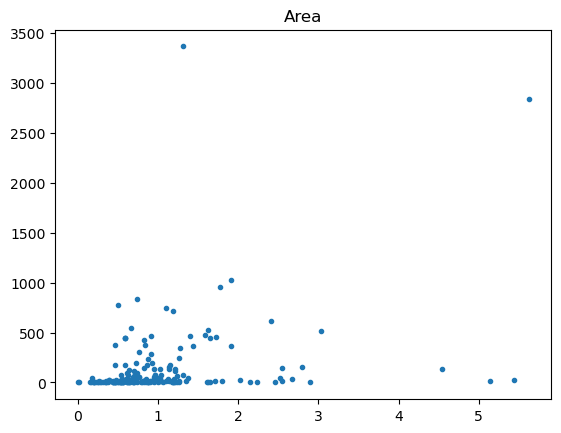

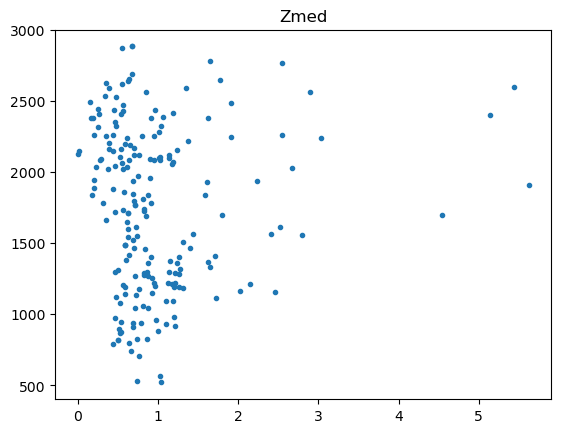

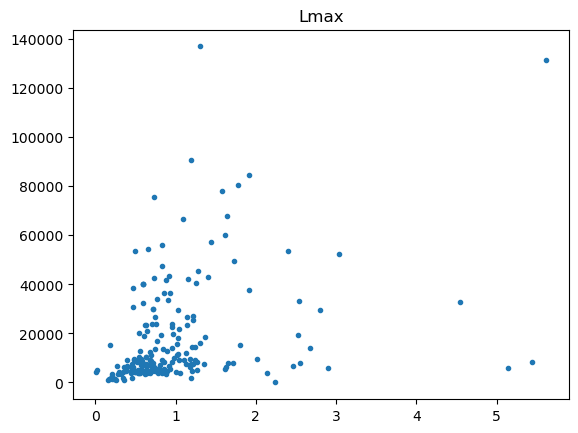

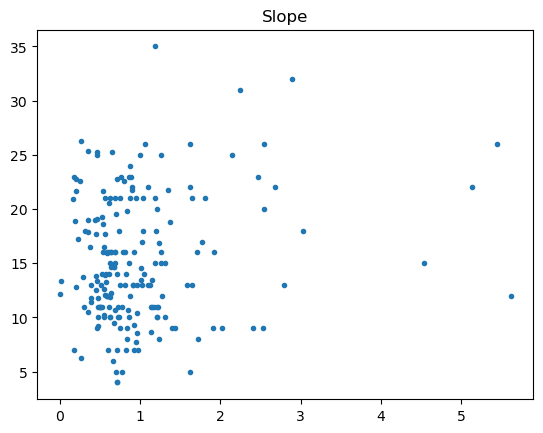

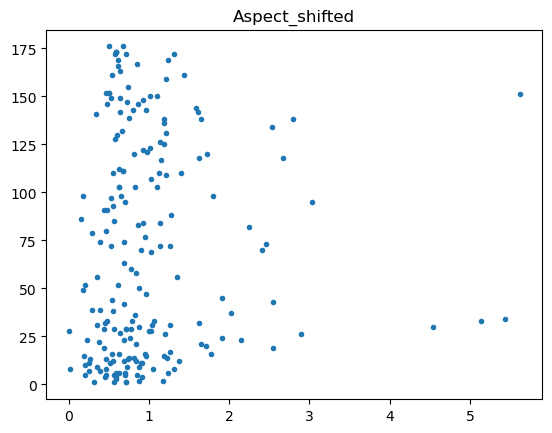

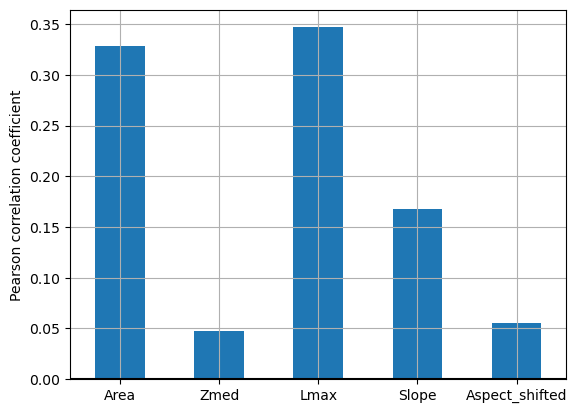

Correlation coefficients saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/results/corr_coeffs_coef_PDDs_median_terrain_params_monthly.csv


In [40]:
# -----Monthly ELAs
# Add terrain parameters to monthly observed ELA fits dataframe
fits_aois_merged = fits_obs_monthly_df.merge(aois[['RGIId'] + terrain_params], on='RGIId')

# Iterate over terrain parameters
corrs_df = pd.DataFrame()
for param in terrain_params:
    fits_aois_merged_param = fits_aois_merged[['coef_PDD_median', param]]
    plt.plot(fits_aois_merged_param['coef_PDD_median'], fits_aois_merged_param[param], '.')
    plt.title(param)
    plt.show()
    corr = fits_aois_merged_param.corr().values[0,1]
    corr_df = pd.DataFrame({'Parameter': [param], 'Pearson Correlation Coefficient': [corr]})
    corrs_df = pd.concat([corrs_df, corr_df])
corrs_df.reset_index(drop=True, inplace=True)

# Sort by correlation magnitudes
# corrs_df.sort_values(by='Pearson Correlation Coefficient', key=abs, ascending=False, inplace=True)

# Plot
fig, ax = plt.subplots()
corrs_df.plot.bar(ax=ax)
ax.grid()
ax.legend().remove()
ax.set_xticks(np.arange(0,len(terrain_params)))
ax.set_xticklabels(terrain_params, rotation=0)
ax.set_ylabel('Pearson correlation coefficient')
ax.axhline(0, color='k')
plt.show()

# Save to file
corrs_fn = os.path.join(scm_path, 'results', 'corr_coeffs_coef_PDDs_median_terrain_params_monthly.csv')
corrs_df.to_csv(corrs_fn, index=False)
print('Correlation coefficients saved to file:', corrs_fn)


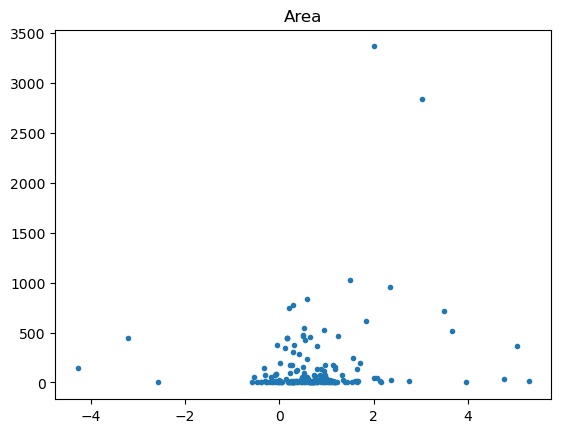

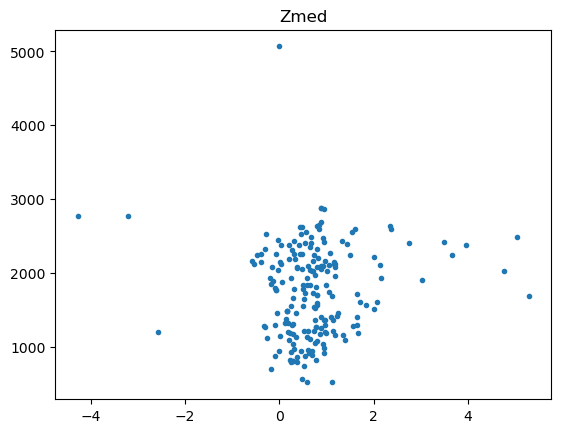

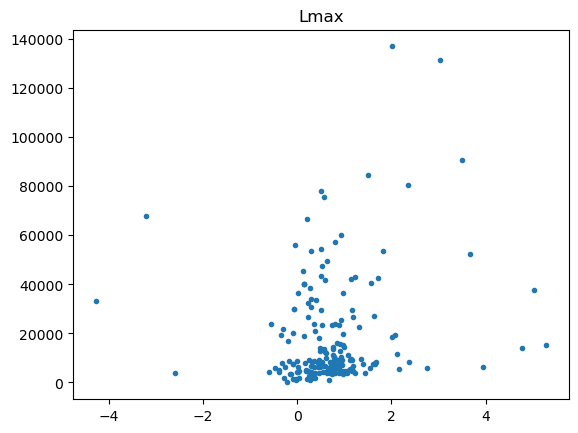

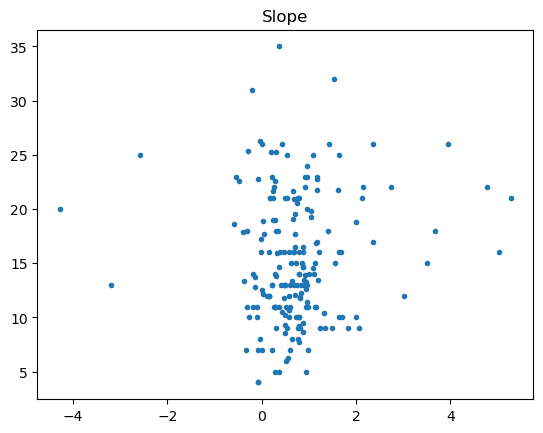

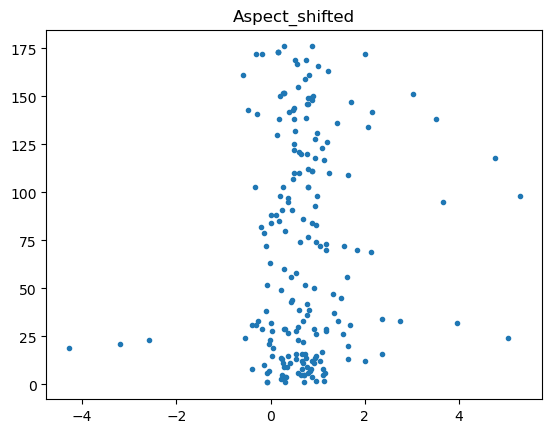

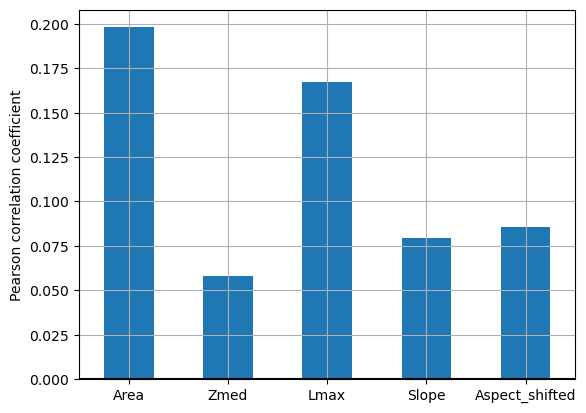

Correlation coefficients saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/results/corr_coeffs_coef_PDDs_median_terrain_params_annual.csv


In [41]:
# -----Annual ELAs
# Define terrain parameters to test
terrain_params = ['Area', 'Zmed', 'Lmax', 'Slope', 'Aspect_shifted']

# Add terrain parameters to monthly observed ELA fits dataframe
fits_aois_merged = fits_obs_annual_df.merge(aois[['RGIId'] + terrain_params], on='RGIId')

# Iterate over terrain parameters
corrs_df = pd.DataFrame()
for param in terrain_params:
    fits_aois_merged_param = fits_aois_merged[['coef_PDD_median', param]]
    plt.plot(fits_aois_merged_param['coef_PDD_median'], fits_aois_merged_param[param], '.')
    plt.title(param)
    plt.show()
    corr = fits_aois_merged_param.corr().values[0,1]
    corr_df = pd.DataFrame({'Parameter': [param], 'Pearson Correlation Coefficient': [corr]})
    corrs_df = pd.concat([corrs_df, corr_df])
corrs_df.reset_index(drop=True, inplace=True)

# Sort by correlation magnitudes
# corrs_df.sort_values(by='Pearson Correlation Coefficient', key=abs, ascending=False, inplace=True)

# Plot
fig, ax = plt.subplots()
corrs_df.plot.bar(ax=ax)
ax.grid()
ax.legend().remove()
ax.set_xticks(np.arange(0,len(terrain_params)))
ax.set_xticklabels(terrain_params, rotation=0)
ax.set_ylabel('Pearson correlation coefficient')
ax.axhline(0, color='k')
plt.show()

# Save to file
corrs_fn = os.path.join(scm_path, 'results', 'corr_coeffs_coef_PDDs_median_terrain_params_annual.csv')
corrs_df.to_csv(corrs_fn, index=False)
print('Correlation coefficients saved to file:', corrs_fn)

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=aois, x='CenLon', y='CenLat', hue='Slope', ax=ax)
plt.show()